# **Step 2 Rule-Based Prediction**

Step 2 of this project uses heuristically determined rules to predicted the CEFR Level of a given text. This notebook explores the various approaches chosen in this project.

In [ ]:
!pip install nltk

In [ ]:
#importing libraries needed for project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

In [ ]:
#reading in files
df = pd.read_csv('Test Data - EN - Sheet1.csv') # test data
df_2 = df.copy() #convienent to have backup
evp_words = pd.read_csv('EVP - Sheet1.csv') # evp graded nouns
evp_data_2 = pd.read_csv('EVP - Nouns_Adjectives - Copy of EVP - Sheet1.csv') # evp graded nouns and adjectives

## Exploratory Data Analysis for CEFR Level Prediction

Let's first look at the test data we are trying to predict.
This test data has been collected from the mostly the British Council and other sources were reading material resources were made available.

[British Council Reading](https://learnenglish.britishcouncil.org/skills/reading)

[Cambridge Exams](https://www.cambridgeenglish.org/exams-and-tests/key/preparation/)

[Council of Europe Resources](https://www.coe.int/en/web/common-european-framework-reference-languages/reading-comprehension)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    101 non-null    object
 1   label   101 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB


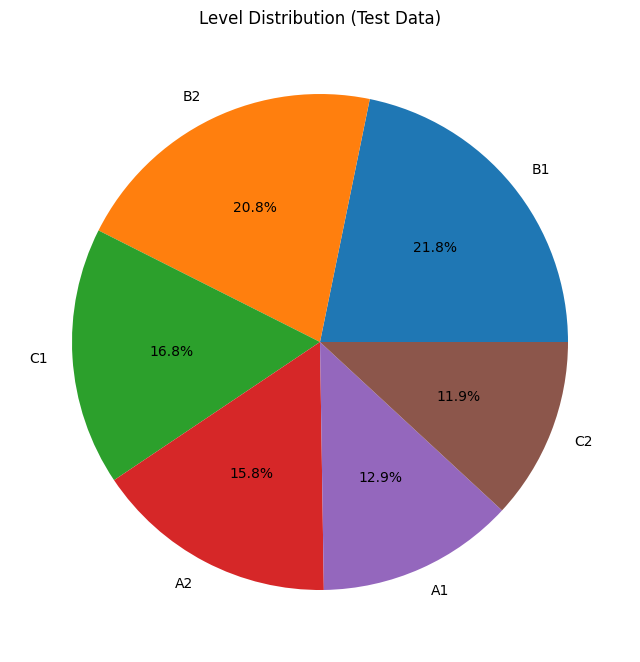

In [ ]:
#pie plot of level distribution
level_distribution = df['label'].value_counts()

#Visualising
level_distribution.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 18))
plt.title('Level Distribution (Test Data)')
plt.ylabel('')
plt.show()

Text length is likely to be a factor in difficulty level. To get a word count for each example we will tokenize using White Space Tokenizer. We will also lowercase all words to make it easier for later data analysis.
Further Resources:

*  [Pandas iloc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)
*  [WhiteSpaceTokenizer](https://www.google.com/url?q=https%3A%2F%2Fwww.nltk.org%2Fapi%2Fnltk.tokenize.html)

In [ ]:
#tokenizing, creating word count column and lowercasing
from nltk.tokenize import WhitespaceTokenizer
df.loc[:, 'text'] = df['text'].apply(lambda x: WhitespaceTokenizer().tokenize(x.lower()))
df['word count'] = df.loc[:, 'text'].apply(lambda x: len(x))

In [ ]:
df.head()

,text,label,word count
0,"[hi, aziz!, are, you, there?, hello?, hello?!?...",A1,99
1,"[first, name:, samia, last, name:, khan, date,...",A1,87
2,"[mario, called., he, wants, you, to, call, bac...",A1,52
3,"[do, you, like, cars?, are, you, friendly, and...",A1,167
4,"[city, flat, beautiful, two-bedroom, city, fla...",A1,167


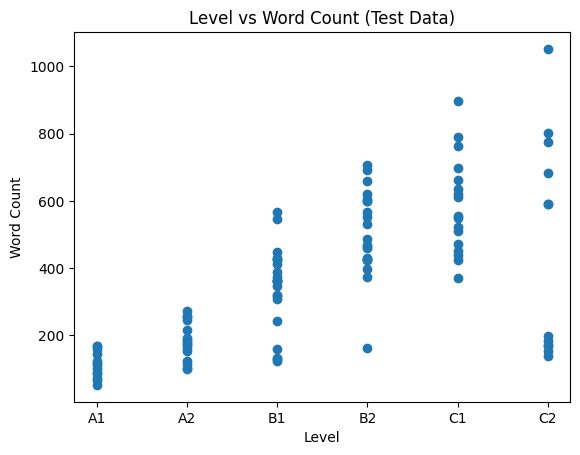

In [ ]:
#visulaing how text length affects level
plt.scatter(df['label'], df['word count'])
plt.figsize = (12,14)
plt.xlabel('Level')
plt.ylabel('Word Count')
plt.title('Level vs Word Count (Test Data)')
plt.show()

From the above graph we can see that lower levels have shorter word counts. The appears to be a cluster of low word count C2 examples. This is probably due to excerpts being split into sub-examples.



Next we will  determine length thresholds to predict the level with.

In [ ]:
#splitting data into levels
a1_df = df[df['label'] == 'A1']
a2_df = df[df['label'] == 'A2']
b1_df = df[df['label'] == 'B1']
b2_df = df[df['label'] == 'B2']
c1_df = df[df['label'] == 'C1']
c2_df = df[df['label'] == 'C2']

In [ ]:
#determining minimum length, maximum length and mean length of text
min_a1 = a1_df['word count'].min()
max_a1 = a1_df['word count'].max()
mean_a1 = a1_df['word count'].mean()

min_a2 = a2_df['word count'].min()
max_a2 = a2_df['word count'].max()
mean_a2 = a2_df['word count'].mean()

min_b1 = b1_df['word count'].min()
max_b1 = b1_df['word count'].max()
mean_b1 = b1_df['word count'].mean()

min_b2 = b2_df['word count'].min()
max_b2 = b2_df['word count'].max()
mean_b2 = b2_df['word count'].mean()

min_c1 = c1_df['word count'].min()
max_c1 = c1_df['word count'].max()
mean_c1 = c1_df['word count'].mean()

min_c2 = c2_df['word count'].min()
max_c2 = c2_df['word count'].max()
mean_c2 = c2_df['word count'].mean()

print(f'A1: Minimum Length = {min_a1}, Maximum Length = {max_a1}, Mean A1 Length = {mean_a1:.0f}')
print(f'A2: Minimum Length = {min_a2}, Maximum Length = {max_a2}, Mean A2 Length = {mean_a2:.0f}')
print(f'B1: Minimum Length = {min_b1}, Maximum Length = {max_b1}, Mean B1 Length = {mean_b1:.0f}')
print(f'B2: Minimum Length = {min_b2}, Maximum Length = {max_b2}, Mean B2 Length = {mean_b2:.0f}')
print(f'C1: Minimum Length = {min_c1}, Maximum Length = {max_c1}, Mean C1 Length = {mean_c1:.0f}')
print(f'C2: Minimum Length = {min_c2}, Maximum Length = {max_c2}, Mean C2 Length = {mean_c2:.0f}')

A1: Minimum Length = 52, Maximum Length = 167, Mean A1 Length = 112
A2: Minimum Length = 98, Maximum Length = 271, Mean A2 Length = 181
B1: Minimum Length = 122, Maximum Length = 567, Mean B1 Length = 342
B2: Minimum Length = 161, Maximum Length = 707, Mean B2 Length = 507
C1: Minimum Length = 369, Maximum Length = 897, Mean C1 Length = 586
C2: Minimum Length = 139, Maximum Length = 1052, Mean C2 Length = 459


In [ ]:
#investigating low c2 word count
c2_investigation = df[df['word count'] == 139]

In [ ]:
print(c2_investigation)

                                                 text label  word count
90  [mobile, communication, for, many, people,, mo...    C2         139


From investigation, it can be seen that the example was most likely from a paragraph of smaller paragraphs and therefore should be merged with the cell above and below. For now, it will be kept as is to keep the 100 samples.

## Method 1: Predicting using length

From investing we can see that the lengths overlap. Two prediction methods will therefore be tried.

The first is based using the min and max, where the max of a level is the min of the next level.
The thresholds therefore are:

*  A1: 1 - 167
*  A2: 168 - 271
*  B1: 272 - 567
*  B2: 568 - 707
*  C1: 708 - 897
*  C2: 898 - 1052


This however, cuts off an unknown number of samples and wrongly classifies them. To generalize better, the max of one level was averaged with the min of the next level. However, for C2 the average value was averaged again with the max of C1 as it was too low given the small C2 samples.
The thresholds for the second prediction are:

*  A1: 1 - 132
*  A2: 132 - 197
*  B1: 198 - 363
*  B2: 364 - 538
*  C1: 539 - 800
*  C2: 801 - 1052

In [ ]:
#predicting based of first thresholds:
def predict_using_length_1(df):
  predicted_level_by_length_1 = []
  for index, row in df.iterrows():
    if row['word count'] > 0 and row['word count'] < 168:
      predicted_level_by_length_1.append('A1')

    elif row['word count'] > 167 and row['word count'] < 272:
      predicted_level_by_length_1.append('A2')

    elif row['word count'] > 271 and row['word count'] < 568:
      predicted_level_by_length_1.append('B1')

    elif row['word count'] > 567 and row['word count'] < 708:
      predicted_level_by_length_1.append('B2')

    elif row['word count'] > 707 and row['word count'] < 898:
      predicted_level_by_length_1.append('C1')

    elif row['word count'] > 897 and row['word count'] < 1053:
      predicted_level_by_length_1.append('C2')

    else:
      predicted_level_by_length_1.append('UNK') # to check if any values were missed - useful for future use
  return predicted_level_by_length_1

In [ ]:
df['predicted_level_by_length_1'] = predict_using_length_1(df)

In [ ]:
df.head()

,text,label,word count,predicted_level_by_length_1
0,"[hi, aziz!, are, you, there?, hello?, hello?!?...",A1,99,A1
1,"[first, name:, samia, last, name:, khan, date,...",A1,87,A1
2,"[mario, called., he, wants, you, to, call, bac...",A1,52,A1
3,"[do, you, like, cars?, are, you, friendly, and...",A1,167,A1
4,"[city, flat, beautiful, two-bedroom, city, fla...",A1,167,A1


In [ ]:
df.tail()

,text,label,word count,predicted_level_by_length_1
96,"[presenter:, last, year,, tim, fitzgerald, exh...",C2,197,A2
97,"[one, of, my, own, thoughts, about, this, piec...",C2,169,A2
98,"[i, want, to, talk, to, you, today, about, a, ...",C2,591,B2
99,"[int.:, today,, we’re, talking, to, marine, bi...",C2,776,C1
100,"[speaker, one, :, i, knew, i’d, be, short, of,...",C2,589,B2


In [ ]:
#Evaluating
gold_labels = df['label']
predicted_labels_length_1 = df['predicted_level_by_length_1']

In [ ]:
# Get evaluation metrics via classification report
report = classification_report(gold_labels, predicted_labels_length_1)

print(report)


              precision    recall  f1-score   support

          A1       0.50      1.00      0.67        13
          A2       0.67      0.62      0.65        16
          B1       0.44      0.77      0.56        22
          B2       0.47      0.33      0.39        21
          C1       0.60      0.18      0.27        17
          C2       1.00      0.08      0.15        12

    accuracy                           0.50       101
   macro avg       0.61      0.50      0.45       101
weighted avg       0.58      0.50      0.45       101



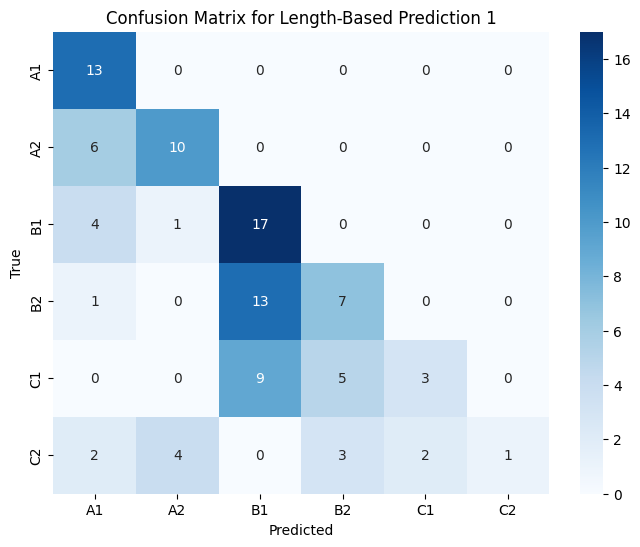

In [ ]:
conf_matrix = confusion_matrix(gold_labels, predicted_labels_length_1)

# Plot the confusion matrix
xticklabels = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
yticklabels = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=xticklabels, yticklabels=yticklabels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Length-Based Prediction 1')
plt.show()

We can see this works well, particularly for lower levels but worsens for higher levels.

Let's try the second threshold values.

In [ ]:
def predict_using_length_2(df):
  predicted_level_by_length_2 = []
  for index, row in df.iterrows():
    if row['word count'] > 0 and row['word count'] < 133:
      predicted_level_by_length_2.append('A1')

    elif row['word count'] > 132 and row['word count'] < 198:
      predicted_level_by_length_2.append('A2')

    elif row['word count'] > 197 and row['word count'] < 364:
      predicted_level_by_length_2.append('B1')

    elif row['word count'] > 363 and row['word count'] < 539:
      predicted_level_by_length_2.append('B2')

    elif row['word count'] > 538 and row['word count'] < 801 :
      predicted_level_by_length_2.append('C1')

    elif row['word count'] > 800 and row['word count'] < 1053:
      predicted_level_by_length_2.append('C2')

    else:
      predicted_level_by_length_2.append('UNK')
  return predicted_level_by_length_2

In [ ]:
df['predicted_level_by_length_2'] = predict_using_length_2(df)

In [ ]:
df.tail()

,text,label,word count,predicted_level_by_length_1,predicted_level_by_length_2
96,"[presenter:, last, year,, tim, fitzgerald, exh...",C2,197,A2,A2
97,"[one, of, my, own, thoughts, about, this, piec...",C2,169,A2,A2
98,"[i, want, to, talk, to, you, today, about, a, ...",C2,591,B2,C1
99,"[int.:, today,, we’re, talking, to, marine, bi...",C2,776,C1,C1
100,"[speaker, one, :, i, knew, i’d, be, short, of,...",C2,589,B2,C1


In [ ]:
predicted_labels_length_2 = df['predicted_level_by_length_2']
report = classification_report(gold_labels, predicted_labels_length_2)
print(report)

              precision    recall  f1-score   support

          A1       0.56      0.69      0.62        13
          A2       0.37      0.44      0.40        16
          B1       0.62      0.36      0.46        22
          B2       0.42      0.52      0.47        21
          C1       0.38      0.53      0.44        17
          C2       0.67      0.17      0.27        12

    accuracy                           0.46       101
   macro avg       0.50      0.45      0.44       101
weighted avg       0.50      0.46      0.45       101



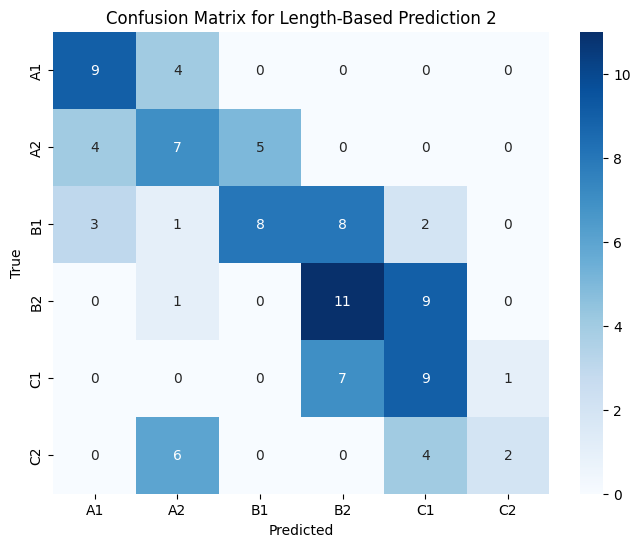

In [ ]:
conf_matrix = confusion_matrix(gold_labels, predicted_labels_length_2)

# Plot the confusion matrix
xticklabels = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
yticklabels = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=xticklabels, yticklabels=yticklabels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Length-Based Prediction 2')
plt.show()

We can see that while the accuracy is lower, these threshold values generalise better for the data, with C1 and C2 improving, and misclassification of these levels at least being misclassified to higher levels.


### Results for length based prediction

Method 1: 50%

Method 2: 48%

## Method 2: EVP-Based Predictions

The English Vocabulary Profile was compiled by the English Profile. It analysed learner sentences from various English exams and determined what words (and their senses) were learned at different CEFR levels for English.

Note: Since these were taken from exam ready students, it is likely that these words are at the higher end of difficulty for the level.

The EVP can be found online and used for non commercial purposes. More information can be found [here.](hhttps://www.englishprofile.org/wordliststtps://)

The aim for this part is to match words from the EVP to the test samples. For each sample, the level will be assigned that has the most EVP words in that sample. The EVP was used as a rough guide and not all words were taken. Many words feature multi-word expressions etc. so only nouns were chosen initially.

Combination of nouns and adjectives were later chosen to compare to the first prediction.

Words that appear in A1 were not chosen to be in A2, although they would be contained within that level. This was done to avoid ambiguity. While efforts were made to ensure the same word does not appear in multiple levels, it is possible that a word could appear if it has a different meaning in that level.
Therefore a word is assigned the highest levels and then the function will move on to the next word.

In [ ]:
#nouns were saved as csv file with 'Base Word' and 'Level' columns
evp_words = pd.read_csv('EVP - Sheet1.csv')
evp_words.head()

,Base Word,Level
0,book,A1
1,name,A1
2,sugar,A1
3,toilet,A1
4,daughter,A1


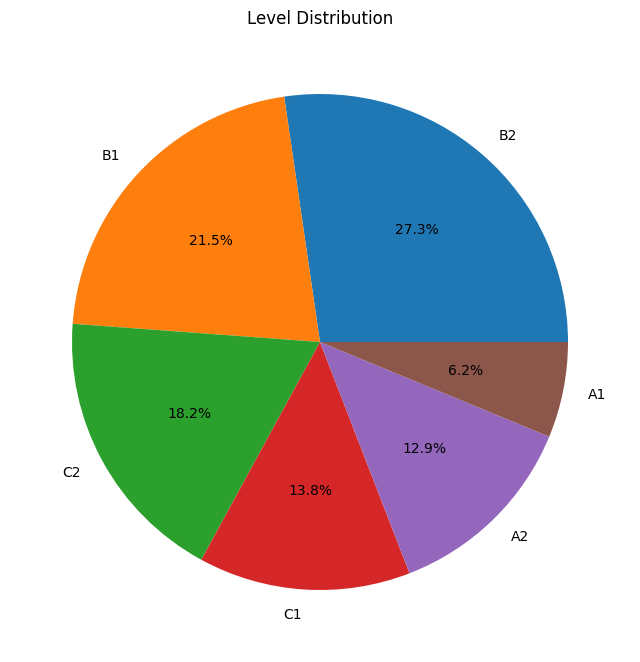

In [ ]:
#pie plot
level_distribution = evp_words['Level'].value_counts()

#Visualising
level_distribution.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 18))
plt.title('Level Distribution')
plt.ylabel('')
plt.show()

In [ ]:
#Creating mini noun banks per level to make it easier to check later
a1_evp = evp_words[evp_words['Level'] == 'A1']
a1_count = len(a1_evp)
a2_evp = evp_words[evp_words['Level'] == 'A2']
a2_count = len(a2_evp)
b1_evp = evp_words[evp_words['Level'] == 'B1']
b1_count = len(b1_evp)
b2_evp = evp_words[evp_words['Level'] == 'B2']
b2_count = len(b2_evp)
c1_evp = evp_words[evp_words['Level'] == 'C1']
c1_count = len(c1_evp)
c2_evp = evp_words[evp_words['Level'] == 'C2']
c2_count = len(c2_evp)

In [ ]:
print(a1_count, a2_count, b1_count, b2_count, c1_count, c2_count)


322 666 1112 1411 714 942


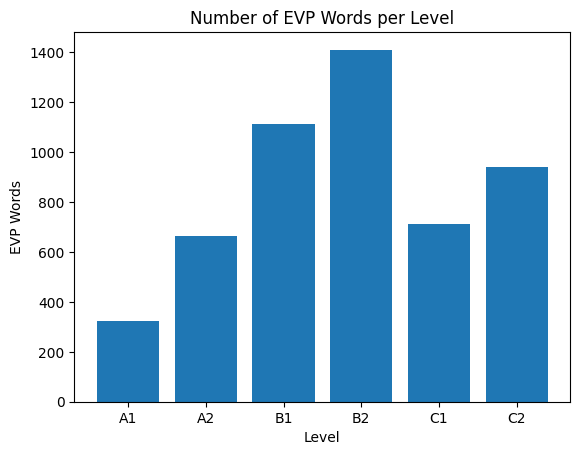

In [ ]:
plt.bar(['A1', 'A2', 'B1', 'B2', 'C1', 'C2'], [a1_count, a2_count, b1_count, b2_count, c1_count, c2_count])
plt.xlabel('Level')
plt.ylabel('EVP Words')
plt.title('Number of EVP Words per Level')
plt.show()

In [ ]:
#Creating a 'mega list' for each level
a1_levels_list = []

for item in a1_evp['Base Word']:
  a1_levels_list.append(item.lower())

a2_levels_list = []

for item in a2_evp['Base Word']:
  a2_levels_list.append(item.lower())

b1_levels_list = []

for item in b1_evp['Base Word']:
  b1_levels_list.append(item.lower())

b2_levels_list = []

for item in b2_evp['Base Word']:
  b2_levels_list.append(item.lower())

c1_levels_list = []

for item in c1_evp['Base Word']:
  c1_levels_list.append(item.lower())

c2_levels_list = []

for item in c2_evp['Base Word']:
  c2_levels_list.append(item.lower())

In [ ]:
#checking
print(len(a1_levels_list), len(a2_levels_list), len(b1_levels_list), len(b2_levels_list), len(c1_levels_list), len(c2_levels_list))

322 666 1112 1411 714 942


Before implementing, check approach works with single example

In [ ]:
test_element = df['text'].iloc[0] # select first sample (which we know is A1)
#testing approach
level_list_test = []
for item in test_element:
  if item in a1_levels_list:
    level_list_test.append('A1')

  elif item in a2_levels_list:
    level_list_test.append('A2')

  elif item in b1_levels_list:
    level_list_test.append('B1')

  elif item in b2_levels_list:
    level_list_test.append('B2')

  elif item in c1_levels_list:
    level_list_test.append('C1')

  elif item in c2_levels_list:
    level_list_test.append('C2')

  else:
    level_list_test.append('UNK')


In [ ]:
level_list_test

['UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'B1',
 'A1',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'A2',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'A2',
 'A1',
 'UNK',
 'UNK',
 'UNK',
 'B1',
 'UNK',
 'A1',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'B1',
 'UNK',
 'B2',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'A2',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'UNK']

We can see most are 'UNK' but some words are being classified.

In [ ]:
#storing results in a dictionary
label_counts = Counter(level_list_test)

level_dict = dict(label_counts)

print(level_dict)

{'UNK': 89, 'B1': 3, 'A1': 3, 'A2': 3, 'B2': 1}


In [ ]:
#creating level_checker function
def level_checker(test_element):
  level_list_test_all = []
  for item in test_element:

    if item in a1_levels_list:
      level_list_test_all.append('A1')

    elif item in a2_levels_list:
      level_list_test_all.append('A2')

    elif item in b1_levels_list:
      level_list_test_all.append('B1')

    elif item in b2_levels_list:
      level_list_test_all.append('B2')

    elif item in c1_levels_list:
      level_list_test_all.append('C1')

    elif item in c2_levels_list:
      level_list_test_all.append('C2')

    else:
      level_list_test_all.append('UNK')
  return level_list_test_all


In [ ]:
#create a column applying the level checker:
df['level_list'] = df['text'].apply(level_checker)

In [ ]:
df.head()

,text,label,word count,predicted_level_by_length_1,predicted_level_by_length_2,level_list
0,"[hi, aziz!, are, you, there?, hello?, hello?!?...",A1,99,A1,A1,"[UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, ..."
1,"[first, name:, samia, last, name:, khan, date,...",A1,87,A1,A1,"[UNK, UNK, UNK, UNK, UNK, UNK, A1, UNK, UNK, U..."
2,"[mario, called., he, wants, you, to, call, bac...",A1,52,A1,A1,"[UNK, UNK, UNK, UNK, UNK, UNK, A2, A2, UNK, UN..."
3,"[do, you, like, cars?, are, you, friendly, and...",A1,167,A1,A2,"[UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, ..."
4,"[city, flat, beautiful, two-bedroom, city, fla...",A1,167,A1,A2,"[A1, A1, UNK, UNK, A1, A1, UNK, UNK, A2, UNK, ..."


In [ ]:
#Creating dictionary column for each sample
df['Level Dictionary EVP 1 '] =df['level_list'].apply(lambda x: dict(Counter(x) if 'UNK' not in x else {k: v for k, v in dict(Counter(x)).items() if k != 'UNK'}))

In [ ]:
#choosing the level with the most words present in sample
df['predicted_lables_evp_1'] = df['Level Dictionary EVP 1 '].apply(lambda x: max(x, key=x.get)) #max(x) will return the highest level label shown, not max counts

In [ ]:
df.head()

,text,label,word count,predicted_level_by_length_1,predicted_level_by_length_2,level_list,Level Dictionary EVP 1,predicted_lables_evp_1
0,"[hi, aziz!, are, you, there?, hello?, hello?!?...",A1,99,A1,A1,"[UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, ...","{'B1': 3, 'A1': 3, 'A2': 3, 'B2': 1}",B1
1,"[first, name:, samia, last, name:, khan, date,...",A1,87,A1,A1,"[UNK, UNK, UNK, UNK, UNK, UNK, A1, UNK, UNK, U...","{'A1': 7, 'A2': 5, 'B1': 1, 'B2': 2, 'C1': 1}",A1
2,"[mario, called., he, wants, you, to, call, bac...",A1,52,A1,A1,"[UNK, UNK, UNK, UNK, UNK, UNK, A2, A2, UNK, UN...","{'A2': 5, 'A1': 2, 'B1': 2}",A2
3,"[do, you, like, cars?, are, you, friendly, and...",A1,167,A1,A2,"[UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, ...","{'A1': 8, 'A2': 10, 'B2': 2, 'B1': 10}",A2
4,"[city, flat, beautiful, two-bedroom, city, fla...",A1,167,A1,A2,"[A1, A1, UNK, UNK, A1, A1, UNK, UNK, A2, UNK, ...","{'A1': 23, 'A2': 9, 'B2': 2, 'B1': 3}",A1


In [ ]:
#getting predictions for confusion matrix
predicted_labels_evp_1 = df['predicted_lables_evp_1']

In [ ]:
report_evp = classification_report(gold_labels, predicted_labels_evp_1)
print(report_evp)

              precision    recall  f1-score   support

          A1       0.23      0.54      0.32        13
          A2       0.13      0.44      0.21        16
          B1       0.36      0.18      0.24        22
          B2       0.00      0.00      0.00        21
          C1       0.00      0.00      0.00        17
          C2       0.00      0.00      0.00        12

    accuracy                           0.18       101
   macro avg       0.12      0.19      0.13       101
weighted avg       0.13      0.18      0.13       101



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


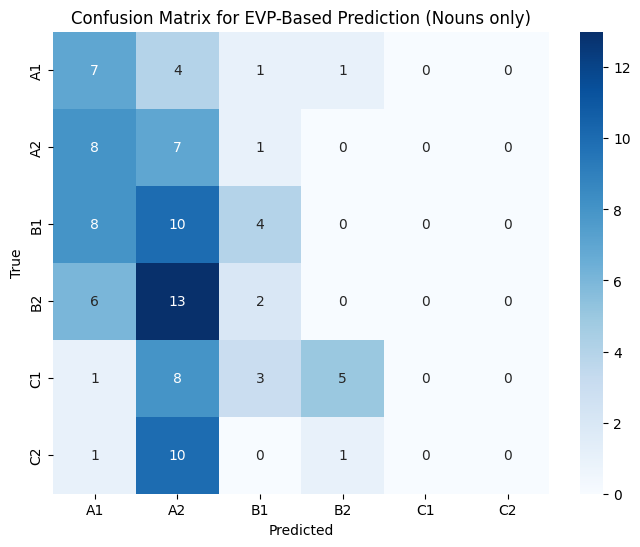

In [ ]:
conf_matrix = confusion_matrix(gold_labels, predicted_labels_evp_1)

# Plot the confusion matrix
xticklabels = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
yticklabels = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=xticklabels, yticklabels=yticklabels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for EVP-Based Prediction (Nouns only)')
plt.show()

We can see that most are getting missclassified to lower levels. This is likely due to the amount of 'UNK' terms hiding the difficulty of the text and also the fact that many lower level words will appear in higher level texts.

We will now add it EVP adjectives to see if this improves the prediction.

In [ ]:
#nouns and adjectives
evp_data_2 = pd.read_csv('EVP - Nouns_Adjectives - Copy of EVP - Sheet1.csv')

In [ ]:
evp_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7587 entries, 0 to 7586
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Base Word  7587 non-null   object
 1   Level      7587 non-null   object
dtypes: object(2)
memory usage: 118.7+ KB


In [ ]:
evp_data_2.tail()

,Base Word,Level
7582,intact,C2
7583,sacred,C2
7584,intolerant,C2
7585,short-sighted,C2
7586,undesirable,C2


In [ ]:
#level specific nouns and adjectives
a1_evp_2 = evp_data_2[evp_data_2['Level'] == 'A1']
a1_count_2 = len(a1_evp_2)
a2_evp_2 = evp_data_2[evp_data_2['Level'] == 'A2']
a2_count_2 = len(a2_evp_2)
b1_evp_2 = evp_data_2[evp_data_2['Level'] == 'B1']
b1_count_2 = len(b1_evp_2)
b2_evp_2 = evp_data_2[evp_data_2['Level'] == 'B2']
b2_count_2 = len(b2_evp_2)
c1_evp_2 = evp_data_2[evp_data_2['Level'] == 'C1']
c1_count_2 = len(c1_evp_2)
c2_evp_2 = evp_data_2[evp_data_2['Level'] == 'C2']
c2_count_2 = len(c2_evp_2)

In [ ]:
print(a1_count_2, a2_count_2, b1_count_2, b2_count_2, c1_count_2, c2_count_2)

415 875 1559 2090 1142 1506


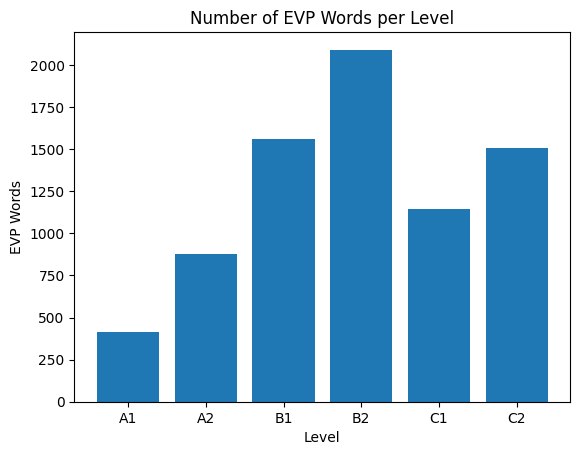

In [ ]:
plt.bar(['A1', 'A2', 'B1', 'B2', 'C1', 'C2'], [a1_count_2, a2_count_2, b1_count_2, b2_count_2, c1_count_2, c2_count_2])
plt.xlabel('Level')
plt.ylabel('EVP Words')
plt.title('Number of EVP Words per Level')
plt.show()

In [ ]:
#mega list for each level
a1_levels_list_2 = []

for item in a1_evp_2['Base Word']:
  a1_levels_list_2.append(item.lower())

a2_levels_list_2 = []

for item in a2_evp_2['Base Word']:
  a2_levels_list_2.append(item.lower())

b1_levels_list_2 = []

for item in b1_evp_2['Base Word']:
  b1_levels_list_2.append(item.lower())

b2_levels_list_2 = []

for item in b2_evp_2['Base Word']:
  b2_levels_list_2.append(item.lower())

c1_levels_list_2 = []

for item in c1_evp_2['Base Word']:
  c1_levels_list_2.append(item.lower())

c2_levels_list_2 = []

for item in c2_evp_2['Base Word']:
  c2_levels_list_2.append(item.lower())

In [ ]:
#level checker for nouns and adjectives in test data
def level_checker_2(test_element):
  level_list_test_all_2 = []
  for item in test_element:

    if item in a1_levels_list_2:
      level_list_test_all_2.append('A1')

    elif item in a2_levels_list_2:
      level_list_test_all_2.append('A2')

    elif item in b1_levels_list_2:
      level_list_test_all_2.append('B1')

    elif item in b2_levels_list_2:
      level_list_test_all_2.append('B2')

    elif item in c1_levels_list_2:
      level_list_test_all_2.append('C1')

    elif item in c2_levels_list_2:
      level_list_test_all_2.append('C2')

    else:
      level_list_test_all_2.append('UNK')
  return level_list_test_all_2


In [ ]:
df['level_list_2'] = df['text'].apply(level_checker_2)

In [ ]:
#Creating dictionary column for each sample
df['Level Dictionary EVP 2 '] =df['level_list_2'].apply(lambda x: dict(Counter(x) if 'UNK' not in x else {k: v for k, v in dict(Counter(x)).items() if k != 'UNK'}))

In [ ]:
#choosing the level with the most words present in sample
df['predicted_lables_evp_2'] = df['Level Dictionary EVP 2 '].apply(lambda x: max(x, key=x.get)) #max(x) will return the highest level label shown, not max counts

In [ ]:
df.tail()

,text,label,word count,predicted_level_by_length_1,predicted_level_by_length_2,level_list,Level Dictionary EVP 1,predicted_lables_evp_1,level_list_2,Level Dictionary EVP 2,predicted_lables_evp_2
96,"[presenter:, last, year,, tim, fitzgerald, exh...",C2,197,A2,A2,"[UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, ...","{'B2': 6, 'A2': 7, 'C1': 2, 'B1': 3}",A2,"[UNK, A2, UNK, UNK, UNK, UNK, UNK, UNK, UNK, U...","{'A2': 14, 'B2': 10, 'C1': 3, 'C2': 3, 'A1': 2...",A2
97,"[one, of, my, own, thoughts, about, this, piec...",C2,169,A2,A2,"[UNK, UNK, UNK, UNK, UNK, UNK, UNK, A2, UNK, U...","{'A2': 11, 'A1': 8}",A2,"[UNK, UNK, UNK, A2, UNK, UNK, UNK, A2, UNK, UN...","{'A2': 12, 'B2': 3, 'A1': 10, 'C2': 1, 'C1': 1}",A2
98,"[i, want, to, talk, to, you, today, about, a, ...",C2,591,B2,C1,"[UNK, UNK, UNK, B1, UNK, UNK, A1, UNK, UNK, B1...","{'B1': 18, 'A1': 14, 'B2': 9, 'A2': 29, 'C1': ...",A2,"[UNK, UNK, UNK, B1, UNK, UNK, A1, UNK, UNK, B1...","{'B1': 29, 'A1': 28, 'C2': 4, 'B2': 18, 'A2': ...",A2
99,"[int.:, today,, we’re, talking, to, marine, bi...",C2,776,C1,C1,"[UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, ...","{'B2': 15, 'A1': 18, 'B1': 22, 'A2': 32, 'C1':...",A2,"[UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, ...","{'B2': 23, 'A1': 25, 'B1': 30, 'A2': 42, 'C2':...",A2
100,"[speaker, one, :, i, knew, i’d, be, short, of,...",C2,589,B2,C1,"[A2, UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, A...","{'A2': 31, 'A1': 29, 'B1': 17, 'C1': 1, 'B2': 10}",A2,"[A2, UNK, UNK, UNK, UNK, UNK, UNK, A1, UNK, A1...","{'A2': 38, 'A1': 38, 'B1': 23, 'C2': 1, 'C1': ...",A2


In [ ]:
df.head()

,text,label,word count,predicted_level_by_length_1,predicted_level_by_length_2,level_list,Level Dictionary EVP 1,predicted_lables_evp_1,level_list_2,Level Dictionary EVP 2,predicted_lables_evp_2
0,"[hi, aziz!, are, you, there?, hello?, hello?!?...",A1,99,A1,A1,"[UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, ...","{'B1': 3, 'A1': 3, 'A2': 3, 'B2': 1}",B1,"[UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, ...","{'B1': 4, 'A1': 6, 'A2': 3, 'B2': 1, 'C2': 1}",A1
1,"[first, name:, samia, last, name:, khan, date,...",A1,87,A1,A1,"[UNK, UNK, UNK, UNK, UNK, UNK, A1, UNK, UNK, U...","{'A1': 7, 'A2': 5, 'B1': 1, 'B2': 2, 'C1': 1}",A1,"[A1, UNK, UNK, A2, UNK, UNK, A1, UNK, UNK, UNK...","{'A1': 8, 'A2': 6, 'B1': 1, 'B2': 2, 'C1': 1}",A1
2,"[mario, called., he, wants, you, to, call, bac...",A1,52,A1,A1,"[UNK, UNK, UNK, UNK, UNK, UNK, A2, A2, UNK, UN...","{'A2': 5, 'A1': 2, 'B1': 2}",A2,"[UNK, UNK, UNK, UNK, UNK, UNK, A2, A2, UNK, UN...","{'A2': 5, 'A1': 3, 'B1': 2}",A2
3,"[do, you, like, cars?, are, you, friendly, and...",A1,167,A1,A2,"[UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, ...","{'A1': 8, 'A2': 10, 'B2': 2, 'B1': 10}",A2,"[UNK, UNK, UNK, UNK, UNK, UNK, A2, UNK, UNK, U...","{'A2': 13, 'A1': 8, 'B2': 2, 'B1': 12}",A2
4,"[city, flat, beautiful, two-bedroom, city, fla...",A1,167,A1,A2,"[A1, A1, UNK, UNK, A1, A1, UNK, UNK, A2, UNK, ...","{'A1': 23, 'A2': 9, 'B2': 2, 'B1': 3}",A1,"[A1, A1, A1, UNK, A1, A1, UNK, UNK, A2, UNK, U...","{'A1': 29, 'A2': 14, 'B2': 2, 'B1': 5}",A1


In [ ]:
predicted_labels_evp_2 = df['predicted_lables_evp_2']

In [ ]:
report_evp = classification_report(gold_labels, predicted_labels_evp_2)
print(report_evp)

              precision    recall  f1-score   support

          A1       0.21      0.62      0.31        13
          A2       0.09      0.25      0.13        16
          B1       0.21      0.14      0.17        22
          B2       0.00      0.00      0.00        21
          C1       0.00      0.00      0.00        17
          C2       0.00      0.00      0.00        12

    accuracy                           0.15       101
   macro avg       0.09      0.17      0.10       101
weighted avg       0.09      0.15      0.10       101



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


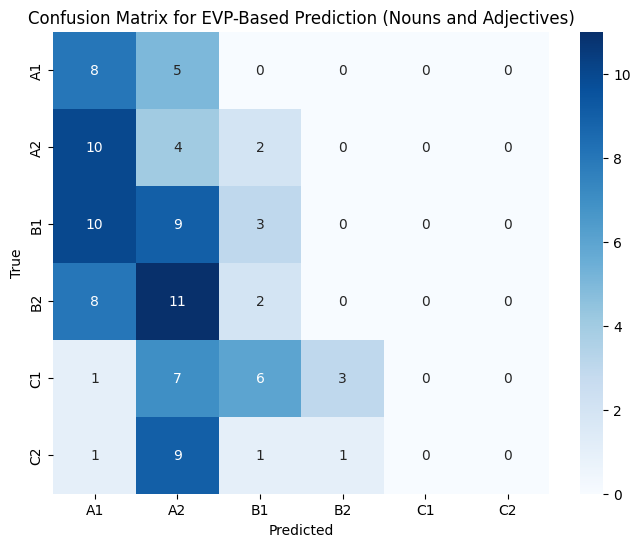

In [ ]:
conf_matrix = confusion_matrix(gold_labels, predicted_labels_evp_2)

# Plot the confusion matrix
xticklabels = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
yticklabels = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=xticklabels, yticklabels=yticklabels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for EVP-Based Prediction (Nouns and Adjectives)')
plt.show()

As we can see neither do well at predicting levels.

Reasons for this may include:

*  Unsuitability of the EVP to test data.
*  Too many words not covered by the EVP selected to highlight true level, for example grammatical constructs.
*  Choosing most words from a level not the best indication for level, many A1 words appear in a C1 text.

Try choose the max item instead, i.e. if 1 C2 word appears, assign a C2 level. This prediction approach, works off the assumption that higher EVP levelled words won't occur at all in lower levels. It is interesting to note, that although B2 has the most amount of EVP words, that does not cause text to be classified as B2, indicating most EVP words are not present in the test data.

In [ ]:
df['predicted_lables_evp_3'] = df['Level Dictionary EVP 2 '].apply(lambda x: max(x)) # will just take 'max key', i.e. highest label.

In [ ]:
df.tail()

,text,label,word count,predicted_level_by_length_1,predicted_level_by_length_2,level_list,Level Dictionary EVP 1,predicted_lables_evp_1,level_list_2,Level Dictionary EVP 2,predicted_lables_evp_2,predicted_lables_evp_3
96,"[presenter:, last, year,, tim, fitzgerald, exh...",C2,197,A2,A2,"[UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, ...","{'B2': 6, 'A2': 7, 'C1': 2, 'B1': 3}",A2,"[UNK, A2, UNK, UNK, UNK, UNK, UNK, UNK, UNK, U...","{'A2': 14, 'B2': 10, 'C1': 3, 'C2': 3, 'A1': 2...",A2,C2
97,"[one, of, my, own, thoughts, about, this, piec...",C2,169,A2,A2,"[UNK, UNK, UNK, UNK, UNK, UNK, UNK, A2, UNK, U...","{'A2': 11, 'A1': 8}",A2,"[UNK, UNK, UNK, A2, UNK, UNK, UNK, A2, UNK, UN...","{'A2': 12, 'B2': 3, 'A1': 10, 'C2': 1, 'C1': 1}",A2,C2
98,"[i, want, to, talk, to, you, today, about, a, ...",C2,591,B2,C1,"[UNK, UNK, UNK, B1, UNK, UNK, A1, UNK, UNK, B1...","{'B1': 18, 'A1': 14, 'B2': 9, 'A2': 29, 'C1': ...",A2,"[UNK, UNK, UNK, B1, UNK, UNK, A1, UNK, UNK, B1...","{'B1': 29, 'A1': 28, 'C2': 4, 'B2': 18, 'A2': ...",A2,C2
99,"[int.:, today,, we’re, talking, to, marine, bi...",C2,776,C1,C1,"[UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, ...","{'B2': 15, 'A1': 18, 'B1': 22, 'A2': 32, 'C1':...",A2,"[UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, ...","{'B2': 23, 'A1': 25, 'B1': 30, 'A2': 42, 'C2':...",A2,C2
100,"[speaker, one, :, i, knew, i’d, be, short, of,...",C2,589,B2,C1,"[A2, UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, A...","{'A2': 31, 'A1': 29, 'B1': 17, 'C1': 1, 'B2': 10}",A2,"[A2, UNK, UNK, UNK, UNK, UNK, UNK, A1, UNK, A1...","{'A2': 38, 'A1': 38, 'B1': 23, 'C2': 1, 'C1': ...",A2,C2


In [ ]:
predicted_labels_evp_3 = df['predicted_lables_evp_3']

In [ ]:
report_evp_3 = classification_report(gold_labels, predicted_labels_evp_3)
print(report_evp_3)

              precision    recall  f1-score   support

          A1       0.00      0.00      0.00        13
          A2       0.00      0.00      0.00        16
          B1       0.00      0.00      0.00        22
          B2       0.00      0.00      0.00        21
          C1       0.00      0.00      0.00        17
          C2       0.13      0.83      0.23        12

    accuracy                           0.10       101
   macro avg       0.02      0.14      0.04       101
weighted avg       0.02      0.10      0.03       101



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


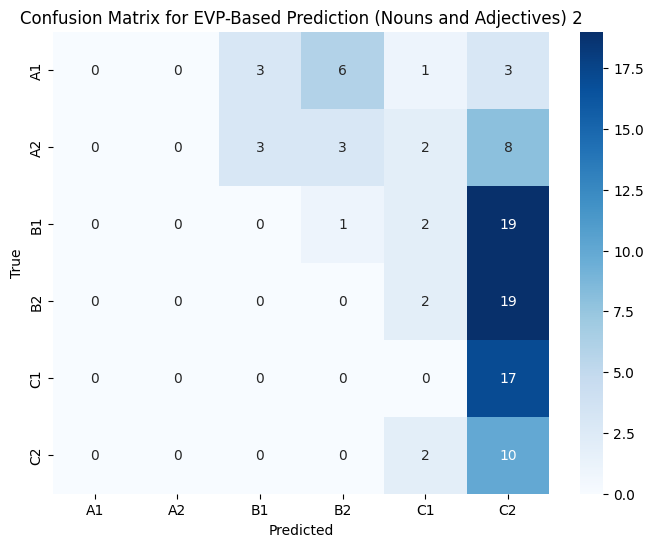

In [ ]:
conf_matrix = confusion_matrix(gold_labels, predicted_labels_evp_3)

# Plot the confusion matrix
xticklabels = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
yticklabels = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=xticklabels, yticklabels=yticklabels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for EVP-Based Prediction (Nouns and Adjectives) 2')
plt.show()

We can see that this prediction has the oppsite problem as the previous methods.
Possible Causes:

*  Word senses: multiple appearances of words being assigned higher level.

*  More EVP needed and more lexical information needed to create robust predictions.

### Results for EVP-Based Predictions

Method 1: 18%

Method 2: 15%

Method 3: 10%


## Final Notes and Future Directions

For this particular test data, length-based predictions out performed other appraoches with them getting an accuracy of 50% and 46%. While length-based method #2 aimed to generalise the prediction better, there is the risk of overfitting as it is entirely plausible to have short C2 passages and long A2 passages.

Future directions this rule-based appraoch could take:
*  Use the [Age of Aqccuistion](https://link.springer.com/article/10.3758/s13428-012-0210-4) and [Leixcal Frequency](https://link.springer.com/article/10.3758/BRM.41.4.977) as factors to determine level.
*  Encorporating more of the EVP, though heavy editing of the EVP would be needed for phrasal verbs, multi-word expressions etc.
*  Weighting the occurence of higher level EVP words with the Frequency to try combine both approaches.
*  Including the English Grammar Profile to capture the grammtical difficulty of the text to classify. [EGP](https://www.englishprofile.org/english-grammar-profile)


As mentioned, the EVP (and EGP) are collected from English Exams and presumably, words may occur from the higher end of the level. The test data, taken from the British Council, is supplementary reading material and therefore is meant for additional quick class exercises. This may be that they are slightly lower in level difficulty. From experience as a teacher, this has been the findings, therefore the suitability of the EVP may not be high for this specific test data.